In [1]:
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set()
import glob     
import numpy as np
from PIL import Image
from collections import Counter
import os
import shutil

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torchsummary import summary
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
# Speeds up convolutiosn by trying different algorithms for computing convolutions
torch.backends.cudnn.benchmark = True

# Load the data path to images
# Rmb to mount your Gdrive
IMG_DIR = '../data/train'

# Batch Size
BATCH_SIZE = 64

# Label Map
label_map = {
    0: "ALB",
    1: "BET",
    2: "DOL",
    3: "LAG",
    4: "NoF",
    5: "OTHER",
    6: "SHARK",
    7: "YFT",
}

# We will assume that all images are of .jpg and .png extensions

In [2]:
def convert_all_images_from_png_to_jpg(IMG_DIR) -> None:
    """
    Converts all .png files to .jpg through PIL .convert("RGB")
    :param IMG_DIR: str

    """
    counter = 0 
    for path in glob.glob(f"{IMG_DIR}/*.png"):
            try:
                im = Image.open(path)
                rgb_im = im.convert("RGB")
                rgb_im.save(path.replace('.png','.jpg'))
                counter += 1
            except:
                print(f"Unable to convert image {path}")
    if counter > 0:
        print("Successfully converted all .png images")
    else:
        print("No .png images")

def build_train_df(IMG_DIR):
    train_labels_df = pd.read_csv(f"{IMG_DIR}/test_labels.csv")
    print(train_labels_df)
    train_data_df = pd.DataFrame([path.replace(f"{IMG_DIR}/","") for path in glob.glob(f"{IMG_DIR}/*.jpg")],columns=['image'])
    print(train_data_df)

    train_df = pd.merge(train_labels_df, train_data_df, how ='inner', on =['image'])
    return train_df

In [3]:
# Split our training dataset to train and valid
def perform_train_valid_split(train_dataset,test_size=0.3,shuffle=True):
    train, valid= train_test_split(
                                            np.arange(len(train_dataset.targets)),
                                            test_size=test_size,
                                            shuffle=shuffle
                                  )

    return train, valid

In [4]:
# For using our pre-trained model VGG16, we need to ensure that we use the exact same pre-processing steps
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
        )

# Load the training and validation dataset
try:  
  dataset = datasets.ImageFolder(IMG_DIR, transform=transform)
  print(dataset)  
except FileNotFoundError:
  raise Exception("Try running cd train and rm -r .ipynb_checkpoints as it causing confusion https://stackoverflow.com/questions/68229246/pytorch-torchvision-datasets-imagefolder-filenotfounderror-found-no-valid-file") 

CLASSES = list(set(dataset.targets))
print([label_map[i] for i in CLASSES])

# randomly split train and validation data, we could also do a simple splice of 0.5 train - 0.5 validate.
valid_split = 0.2
data_size = len(dataset)
valid_size =  int(data_size * valid_split)
train_size =  data_size - valid_size

train_dataset, valid_dataset = random_split(dataset, [train_size,valid_size],generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True)

Dataset ImageFolder
    Number of datapoints: 3777
    Root location: ../data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               RandomAffine(degrees=[-40.0, 40.0], scale=(1, 2), shear=[-15.0, 15.0])
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


c:\Users\USER\Anaconda3\envs\money\lib\site-packages\torchvision\transforms\transforms.py:1362: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
c:\Users\USER\Anaconda3\envs\money\lib\site-packages\torchvision\transforms\transforms.py:1376: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out,title=classes.numpy())

KeyboardInterrupt: 

In [15]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_ft = models.vgg16(pretrained=True)
print(model_ft)

cuda
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [16]:
def weight_builder(label_map,data_size):
  weights = []
  for value in label_map.values():
    weights.append(len(glob.glob(f"{IMG_DIR}/{value}"))/data_size)
  return weights

In [17]:
# Freeze model parameters
for param in model_ft.parameters():
    param.requires_grad = False

# Change the final layer of VGG16 Model for Transfer Learning
# Here the size of each output sample is set to 8
fc_inputs = model_ft.classifier[-4].out_features
model_ft.classifier[-1] = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(CLASSES))
)
# print(model_ft)
model_ft = model_ft.to(device)
# Create weights to handle class imbalance
weights = weight_builder(label_map,data_size)
# added weights to crossentropyloss for class imbalance
loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights).to(device))
# We will use SGD as our opitimiser
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
# Exponentially Decay LR by a factor of 0.1
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [43]:
import copy
plot_train_acc = []
plot_train_loss = []
plot_val_acc = []
plot_val_loss = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_dataloader
                dataset_size = valid_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            if phase == 'train':
                plot_train_loss.append(float(epoch_loss))
                plot_train_acc.append(float(epoch_acc))
            if phase == 'val':
                plot_val_loss.append(float(epoch_loss))
                plot_val_acc.append(float(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
model_ft = train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0736 Acc: 0.6023
val Loss: 1.0225 Acc: 0.6344

Epoch 1/24
----------
train Loss: 1.0840 Acc: 0.6042
val Loss: 0.9904 Acc: 0.6530

Epoch 2/24
----------
train Loss: 1.0750 Acc: 0.6092
val Loss: 0.9956 Acc: 0.6464

Epoch 3/24
----------
train Loss: 1.0634 Acc: 0.6145
val Loss: 1.0083 Acc: 0.6543

Epoch 4/24
----------
train Loss: 1.0585 Acc: 0.6079
val Loss: 0.9935 Acc: 0.6636

Epoch 5/24
----------
train Loss: 1.0589 Acc: 0.6132
val Loss: 1.0061 Acc: 0.6596

Epoch 6/24
----------
train Loss: 1.0898 Acc: 0.6049
val Loss: 1.0099 Acc: 0.6490

Epoch 7/24
----------
train Loss: 1.0795 Acc: 0.6032
val Loss: 1.0316 Acc: 0.6358

Epoch 8/24
----------
train Loss: 1.0640 Acc: 0.6052
val Loss: 0.9966 Acc: 0.6397

Epoch 9/24
----------
train Loss: 1.0751 Acc: 0.6062
val Loss: 1.0077 Acc: 0.6384

Epoch 10/24
----------
train Loss: 1.0784 Acc: 0.6095
val Loss: 1.0175 Acc: 0.6503

Epoch 11/24
----------
train Loss: 1.0650 Acc: 0.6128
val Loss: 1.0150 Acc: 0.6424

Ep

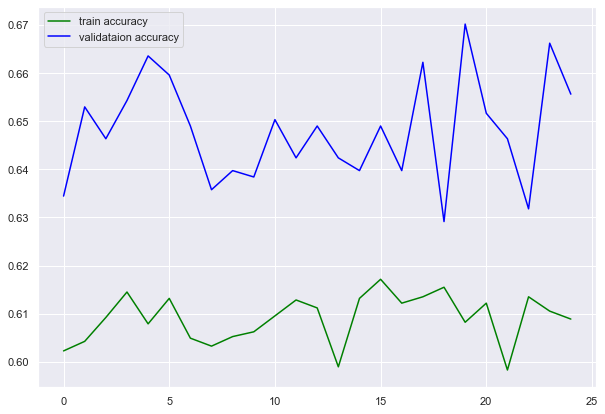

In [44]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_val_acc, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('../images/train_val_accuracy.png')
plt.show()

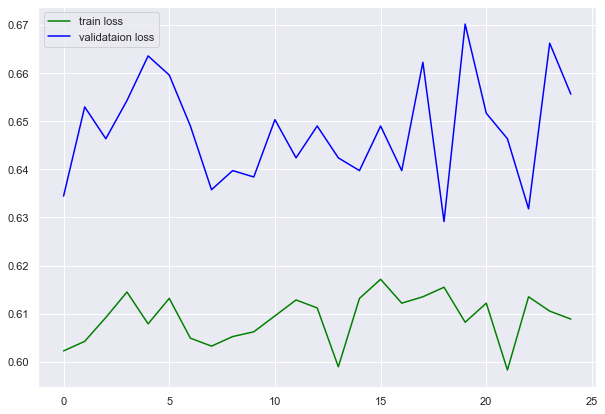

In [45]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train loss')
plt.plot(plot_val_acc, color='blue', label='validataion loss')
plt.legend()
plt.savefig('../images/train_val_loss.png')
plt.show()

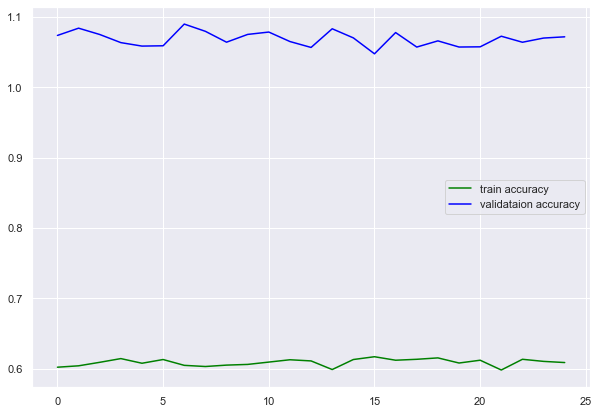

In [46]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_train_loss, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('../images/train_accuracy_loss.png')
plt.show()

In [21]:
torch.save(model_ft, '../models/VGG16_v3_25_0.672.pt')

In [41]:
print(plot_train_acc)
print(plot_train_loss)
print(plot_val_acc)
print(plot_val_loss)

[tensor(0.6201, device='cuda:0', dtype=torch.float64)]
[1.0587443522788451]
[]
[]


0.6201191264063534